# Support Vector Machines y Naive Bayes

<h1>Índice<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Hard-margin-classifier" data-toc-modified-id="Hard-margin-classifier-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Hard margin classifier</a></span></li><li><span><a href="#Soft-margin-classfier" data-toc-modified-id="Soft-margin-classfier-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Soft margin classfier</a></span></li><li><span><a href="#El-poder-de-los-kernels" data-toc-modified-id="El-poder-de-los-kernels-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>El poder de los kernels</a></span><ul class="toc-item"><li><span><a href="#Construcción-de-kernels." data-toc-modified-id="Construcción-de-kernels.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Construcción de kernels.</a></span></li><li><span><a href="#Propiedades-de-algunos-kernels" data-toc-modified-id="Propiedades-de-algunos-kernels-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Propiedades de algunos <em>kernels</em></a></span></li></ul></li><li><span><a href="#Naive-Bayes" data-toc-modified-id="Naive-Bayes-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Naive Bayes</a></span></li></ul></div>

Primero, corremos la celda de preparación.

In [310]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "09_SVM_NB"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "plots", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
# import warnings
# warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [347]:
# Definamos una función práctica
def plot_clasi(x, t, ws, labels=[], xp=[-1., 1.], thr=[0,], spines='zero', equal=True):
    """
    Figura con el resultado del ajuste lineal
    """
    assert len(labels) == len(ws) or len(labels) == 0
    assert len(ws) == len(thr)
    
    if len(labels) == 0:
        labels = np.arange(len(ws)).astype('str')
    
    # Agregemos el vector al plot
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    
    xc1 = x[:, t[0] == np.unique(t).max()]
    xc2 = x[:, t[0] == np.unique(t).min()]
#     xc1 = x[:, t[0] == 1]
#     xc2 = x[:, t[0] == -1]
    
    ax.plot(*xc1, 'ob', mfc='None', label='C1')
    ax.plot(*xc2, 'or', mfc='None', label='C2')

    for i, w in enumerate(ws):
        
        # Ploteo vector de pesos
        x0 = 0.5 * (xp[0] + xp[1])
        ax.quiver(0, thr[i]/w[1], w[0], w[1], color='C{}'.format(i+2), scale=10, label=labels[i],
                 zorder=10)

        # ploteo plano perpendicular
        xp = np.array(xp)
        yp = (thr[i] -w[0]*xp)/w[1] 

        plt.plot(xp, yp, '-', color='C{}'.format(i+2))
        
    # Ploteo línea que une centros de los conjuntos
    mu1 = xc1.mean(axis=1)
    mu2 = xc2.mean(axis=1)
    ax.plot([mu1[0], mu2[0]], [mu1[1], mu2[1]], 'o:k', mfc='None', ms=10)

#     ax.set_xlabel('$x_1$')
#     ax.set_ylabel('$x_2$')
    ax.legend(loc=0, fontsize=12)
    if equal:
        ax.set_aspect('equal')
    
    if spines is not None:
        for a in ['left', 'bottom']:
            ax.spines[a].set_position('zero')
        for a in ['top', 'right']:
            ax.spines[a].set_visible(False)
        
#     ax.set_xlim(-7, 3)
#     ax.set_ylim(-4, 4)
    return

## Hard margin classifier

$\newcommand{\vv}[1]{\boldsymbol{#1}}$
$\newcommand{\om}[0]{\boldsymbol{\omega}}$
$\newcommand{\norm}[0]{\mathcal{N}}$
$\newcommand{\b}[1]{\mathrm{\mathbf{#1}}}$
$\newcommand{\T}{^\mathrm{T}}$
$\newcommand{\cu}{\mathcal{C}_1}$
$\newcommand{\cd}{\mathcal{C}_2}$
Cuando vimos clasificación con modelos lineales, encontramos que para problemas linealmente separables, existe una frontera de decisión que genera una clasificación exacta.

Lo que no quedaba claro es que esa frontera fuera la mejor en términos de generalización.

In [312]:
from numpy.random import multivariate_normal

size1 = 250
mu1 = [0, 0]
cov1 = [[1, 0.95],[0.95, 1]]

size2 = 200
mu2 = [-4, 1.5]
cov2 = [[1, 0.8],[0.8, 1]]

np.random.seed(20200922)
# Sample classes
xc1 = multivariate_normal(mean=mu1, cov=cov1, size=size1).T
xc2 = multivariate_normal(mean=mu2, cov=cov2, size=size2).T

print(xc1.shape, xc2.shape)

# Concatenate both classes
x = np.hstack([xc1, xc2])
tc1 = np.ones((1, xc1.shape[1]))
tc2 = -np.ones((1, xc2.shape[1]))
# tc2 = -np.ones((1, xc2.shape[1]))
t = np.hstack([tc1, tc2])

print(x.shape, t.shape)

(2, 250) (2, 200)
(2, 450) (1, 450)


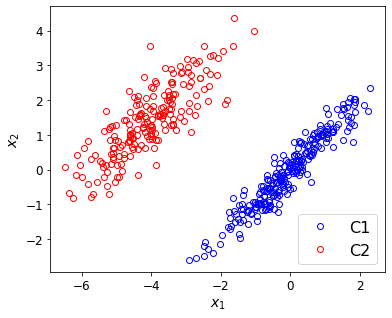

In [313]:
# Veamos cómo se ven
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.plot(*xc1, 'ob', mfc='None', label='C1')
ax.plot(*xc2, 'or', mfc='None', label='C2')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.legend(loc='lower right', fontsize=16)
ax.set_aspect('equal')

Veamos cómo funciona el perceptrón en este caso.

In [314]:
from sklearn.linear_model import Perceptron

perce = Perceptron(max_iter=1000, fit_intercept=False, warm_start=False)

# En ese caso, la matriz de diseño es simplemente x con una columna de unos
phi0 = np.ones([len(x.T), 1])
phi = np.hstack([phi0, x.T.copy()])

# Pero podríamos probar otras cosas, como esto que está comentado más abajo.
perce = perce.fit(phi, t.flatten())

def makew(fitter):
    
    # # Obtengamos los pesos y normalicemos
    w = fitter.coef_.copy()
    
    # # Incluye intercept
    if fitter.fit_intercept:
        w = np.hstack([fitter.intercept_.reshape(1,1), w])
        
    # # Normalizon
    w /= np.linalg.norm(w)
    return w.T

w_perce = makew(perce)

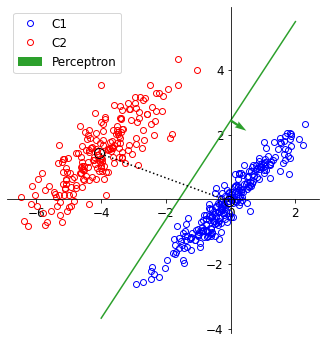

In [315]:
# Comparamos con Fischer
plot_clasi(x, t, [w_perce[1:],], ['Perceptron',], xp=[-4, 2], thr=[-w_perce[0],])

Ok, pero que pasa si le doy otro punto de inicio al perceptrón

[[21.          9.69724574 -7.16178277]]


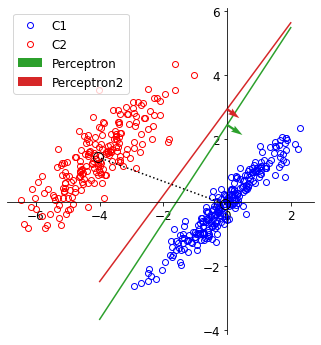

In [316]:
perce2 = Perceptron(max_iter=1000, fit_intercept=False, warm_start=True, random_state=1234)
perce2 = perce2.fit(phi, t.flatten(), coef_init=[1.0, 4.0, 55.0])
w_perce2 = makew(perce2)

print(perce2.coef_)
# print(w_perce2)
# Comparamos con Fischer
plot_clasi(x, t, [w_perce[1:], w_perce2[1:]], ['Perceptron', 'Perceptron2'], xp=[-4, 2], 
           thr=[-w_perce[0], -w_perce2[0]])

In [317]:
perce3 = Perceptron(max_iter=1000, fit_intercept=True, warm_start=True, random_state=1234)
perce3 = perce3.fit(phi[:, 1:], t.flatten(), coef_init=[-34.0, 55.0])

w3 = np.concatenate([perce3.intercept_, perce3.coef_.flatten()])
w3 /= np.sqrt(np.dot(w3.T, w3))

# a = [2, 3, 4]
# b = [1, *a]
# print(b)

# w_perce3 = makew(perce3).T
# print(w3, w_perce2)

# print(w_perce3)
# # Comparamos con Fischer
# plot_clasi(x, t, [w_perce3, w_perce2[1:]], ['Perceptron3', 'Perceptron2'], xp=[-4, 2], 
#            thr=[-perce3.intercept_, -w_perce2[0]])

Podemos preguntarnos cuál de las dos soluciones es mejor. Y por qué...

Una alternativa más robusta es usar clasificadores de margen, como vimos en las diapos recién.

In [318]:
from sklearn.svm import LinearSVC, SVC

# Instancio
svc = LinearSVC(loss='hinge', C=np.infty, fit_intercept=False)

# Matrix de diseño
phi0 = np.ones([len(x.T), 1])
phi = np.hstack([phi0, x.T.copy()])
# phi = x.T.copy()

# Ajusto
svc.fit(phi, t.flatten())

w_hmc = makew(svc)

print(w_hmc)

[[ 0.85008541]
 [ 0.36256833]
 [-0.38196728]]


Podemos encontrar los *support vectors* encontrando los puntos que tienen valor de la función $y(\mathbf{x})<= 1$.

In [319]:
# Find support vectors
isv = np.abs(svc.decision_function(phi)) <= 1.0 + 1e-12

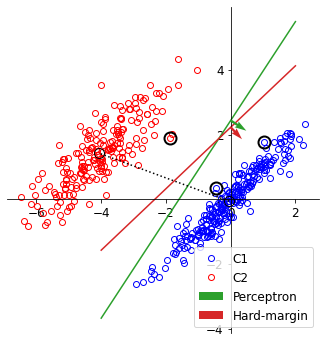

In [320]:
plot_clasi(x, t, [w_perce[1:], w_hmc[1:]], ['Perceptron', 'Hard-margin',], xp=[-4, 2], 
           thr=[-w_perce[0], -w_hmc[0]])

# Plot support vectors
plt.plot(x[0, isv], x[1, isv], 'o', ms=12, mfc='None', mec='k', mew=2)

## Soft margin classfier

Veamos ahora qué pasa si los conjuntos de datos no son linealmente separables. Uso el mismo modelo generativo pero con otros modelos.

In [321]:
from numpy.random import multivariate_normal

size1 = 250
mu1 = [0, 0]
cov1 = [[1, 0.95],[0.95, 1]]

size2 = 250
mu2 = [-1, 1]
#mu2 = [0, 0]
cov2 = [[1, 0.8],[0.8, 1]]

np.random.seed(20200922)
# Sample classes
xc1 = multivariate_normal(mean=mu1, cov=cov1, size=size1).T
xc2 = multivariate_normal(mean=mu2, cov=cov2, size=size2).T

print(xc1.shape, xc2.shape)

# Concatenate both classes
x = np.hstack([xc1, xc2])
tc1 = np.ones((1, xc1.shape[1]))
tc2 = -np.ones((1, xc2.shape[1]))
# tc2 = -np.ones((1, xc2.shape[1]))
t = np.hstack([tc1, tc2])

print(x.shape, t.shape)

(2, 250) (2, 250)
(2, 500) (1, 500)


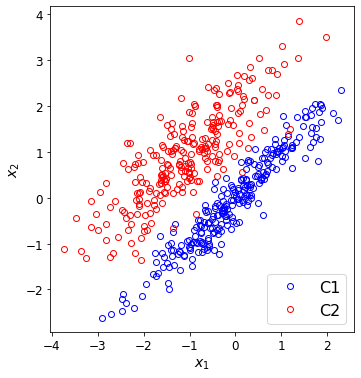

In [322]:
# Veamos cómo se ven
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.plot(*xc1, 'ob', mfc='None', label='C1')
ax.plot(*xc2, 'or', mfc='None', label='C2')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.legend(loc='lower right', fontsize=16)
ax.set_aspect('equal')

Sadismo algortímico: probemos qué hace el perceptrón.

In [323]:
perce = Perceptron(max_iter=1000, tol=1e-10, fit_intercept=False, warm_start=False)

# En ese caso, la matriz de diseño es simplemente x con una columna de unos
phi0 = np.ones([len(x.T), 1])
phi = np.hstack([phi0, x.T.copy()])

# Pero podríamos probar otras cosas, como esto que está comentado más abajo.
perce = perce.fit(phi, t.flatten())

w_perce = makew(perce)
print(w_perce)

[[ 0.44212713]
 [ 0.62153633]
 [-0.64669637]]


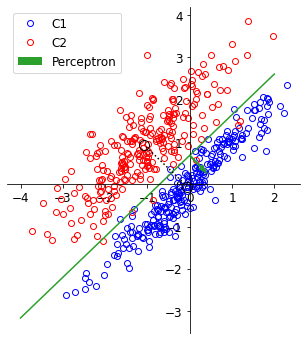

In [324]:
# Veamos cómo le fue
plot_clasi(x, t, [w_perce[1:],], ['Perceptron',], xp=[-4, 2], thr=[-w_perce[0],])

In [325]:
# Instancio
# hmc = LinearSVC(C=np.infty, fit_intercept=True, max_iter=1000)
smc = LinearSVC(C=1.0, fit_intercept=False, max_iter=1000)
# smc = SVC(kernel='linear', degree=1, C=0.005, max_iter=1000)

# Matrix de diseño
phi = np.hstack([phi0, x.T.copy()])
# phi = x.T.copy()

# Ajusto
# hmc.fit(phi, t.flatten())
smc.fit(phi, t.flatten())

# w_hmc = makew(hmc).T
w_smc = makew(smc)

print(w_smc)

[[ 0.47446649]
 [ 0.61531804]
 [-0.62949604]]


In [326]:
isv = np.abs(smc.decision_function(phi)) <= 1

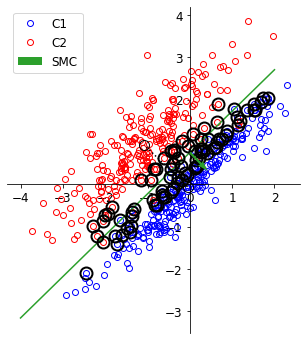

In [327]:
plot_clasi(x, t, [w_smc[1:],], ['SMC', ], xp=[-4, 2], thr=[-w_smc[0],])

plt.plot(x[0, isv], x[1, isv], 'o', ms=12, mfc='None', mec='k', mew=2)
# plt.plot(smc.support_vectors_[:, 0], smc.support_vectors_[:, 1], 'o', ms=12, mfc='None', mec='k', mew=2)

Encontremos el valor de la variable de regularización usando CV

In [328]:
from sklearn.model_selection import GridSearchCV

parameters = {'C': np.logspace(-3, 0, 10)}

gscv = GridSearchCV(smc, parameters, cv=5)
gscv.fit(phi, t.flatten())

GridSearchCV(cv=5, estimator=LinearSVC(fit_intercept=False),
             param_grid={'C': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ])})

In [329]:
print(gscv.best_params_)
smc = gscv.best_estimator_
smc.fit(phi, t.flatten())

w_smc = makew(smc)

{'C': 0.004641588833612777}


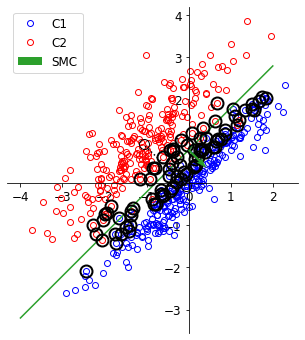

In [330]:
plot_clasi(x, t, [w_smc[1:],], ['SMC', ], xp=[-4, 2], thr=[-w_smc[0],])

plt.plot(x[0, isv], x[1, isv], 'o', ms=12, mfc='None', mec='k', mew=2)

## El poder de los kernels

Vimos que el problema de optimización de las SVM puede expresarse de una forma dual, en la que la función a optimizar (el Lagrangeano) toma la forma

$$
L(\mathbf{a}) = \sum_{n=1}^N a_n - \frac{1}{2} \sum_{n=1}^N \sum_{m=1}^N a_n a_m t_n t_m k(\mathbf{x}_n, \mathbf{x}_m)\;\;,
$$
donde los $a_n$ son los multiplicadores de Lagrange que permiten optimizar el margen manteniendo la menor cantidad de puntos del lado correcto. Esta función hay que optimizarla con las siguientes condiciones:

$$
\begin{array}{c}
0 \leq a_n \leq C\\
 \sum_{m=1}^N a_n t_n = 0\;\;,
 \end{array}
 $$
 y donde 
 
 $$
 \boxed{k(x, x^\prime) = \boldsymbol{\phi}(x)\T \boldsymbol{\phi}(x^\prime) = \sum_{i=1}^M \phi_i(x)\T \phi_i(x^\prime)}\;\;.$$

### Construcción de kernels.

 Para construir un *kernel* válido, entonces, podemos definir un conjunto de funciones de base $\phi_i$, para $i = 1, \ldots, M$ y después realizar el producto de la ecuación de arriba.
 
 Pero la verdadera versatilidad de la técnica aparece cuando uno define directamente una función de *kernel*. Pero en este caso, hay que asegurar de que se trata de una función válida, es decir, que corresponde a un producto de vectores de funciones de base, $\boldsymbol{\phi}(x)$.
 
Una condición necesaria y suficiente es que la matriz de Gram, $\mathbf{K}$, cuyo elemento $n, m$ es $k(\mathbf{x}_n, \mathbf{x}_m)$ sea semidefinida positiva. Esto quiere decir, que debe cumplirse que

$$
\mathbf{v}\T \mathbf{K} \mathbf{v} \geq 0\;\;
$$
para cualquier vector $\mathbf{v}$. Esto es equivalente a pedir que los autovalores de la matriz de Gram sean mayores o iguales que cero.

*Nota:* atención que esto no es equivalente a decir que todos los elementos de la matriz sean positivos. En el Bishop aparece el ejemplo de la inocente matriz
$$
\begin{pmatrix}
1 & 2\\
3 & 4\\
\end{pmatrix}\;\;,
$$
que tiene autovalores $\lambda_1 = 5.37$ y $\lambda_2 = -0.37$ y por lo tanto no es semidefinida positiva.

Una manera potente es usar *kernels* básicos para construir *kernels* más sofisticados, usando las siguientes propiedades (sacadas del Bishop):

<img src='images/kernelconstruction.png'>

### Propiedades de algunos *kernels*

$\newcommand{\k}[0]{k(\mathbf{x}, \mathbf{x}^\prime)}$
$\newcommand{\x}[0]{\mathbf{x}}$
Podemos ver que el kernel $\k = (\mathbf{x}\T \mathbf{x}^\prime)^2$ tiene términos de grado dos. En dos dimensiones, $\mathbf{x} = (x_1, x_2)$

$$
\begin{array}{ll}
(\mathbf{x}\T \mathbf{z})^2 &= (x_1 z_1 + x_2 z_2)^2\\
                            &= x_1^2 z_1^2 + 2 x_1 z_1 x_2 z_2 + x_2^2 z_2^2\\
                            &= (x_1^2, \sqrt{2}x_1 x_2, x_2^2) (z_1^2, \sqrt{2}z_1 z_2, z_2^2)\T\\
                            &= \boldsymbol{\phi}(\mathbf{x})\T \boldsymbol{\phi}(\mathbf{z})\;\;.
\end{array}
$$

De la misma manera, $\k = (\mathbf{x}\T \mathbf{x}^\prime)^M$ tiene todos los términos de grado $M$. 

Por otro lado $\k = (\mathbf{x}\T \mathbf{x}^\prime + c)^2$ corresponde a un vector de funciones de base que contiene términos constantes y lineales, además de los de orden dos.

***
**Ejercicio** Probar esto último.
***

Uno de los *kernels* más interesantes es el llamado "Gaussiano" o Radial Basis Function (RBF):

$$
\k = \exp{\left(\x\T \x\right)}
$$

que tiene una forma gaussiana, pero no tiene normalización ni nada por el estilo.

**Nota** En `sklearn`, este kernel está parametrizado diferente, usando el parámetro $\gamma$:
$$
\k = \exp{\left(-\gamma ||\mathbf{x} - \mathbf{x}^\prime||^2\right)}\;\;,
$$
***

Se puede ver que este *kernel* es válido desarrollando el cuadrado,

$$
\k = \exp{\left(-\x\T \x \mathbin{/} {2\sigma^2} \right)}\exp{\left(\x\T \x^\prime /\sigma^2 \right)}\exp{\left(-(\x^\prime)\T \x^\prime/2\sigma^2 \right)}\;\;,
$$
y usando las propiedades que pusimos más arriba.

Una característica interesante de este *kernel* es que se corresponde con un vector de funciones de base de dimensiones infinitas. Para ver eso.

Veamos cómo funciona este *kernel* con el conjunto de datos de recién e intentemos ver qué rol juegan los hiperparámetros $\gamma$ y $C$.

In [420]:
from sklearn.svm import SVC

# Instancio clase
svc_rbf = SVC(kernel='rbf', C=10000.0, gamma=0.00001)
svc_rbf.fit(x.T, t.flatten())

SVC(C=10000.0, gamma=1e-05)

(-4.734935045667795, 3.2918752159382967, -3.612224784500068, 4.848661921903149)

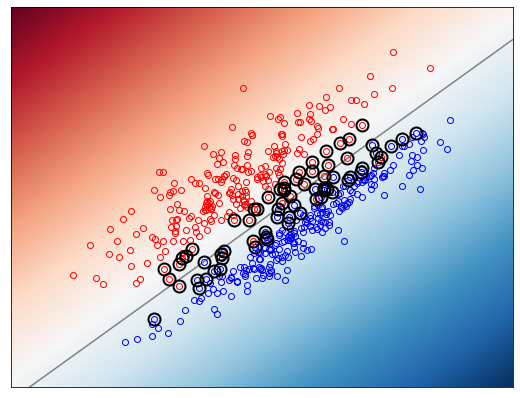

In [468]:
plt.figure(figsize=(9, 7))

xx, yy = np.meshgrid(np.linspace(x[0].min()-1, x[0].max()+1, 200), 
                     np.linspace(x[1].min()-1, x[1].max()+1, 200))

# evaluate decision function
Z = svc_rbf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# veamos la función de decisión y la frontera de decisión
plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu_r)
plt.contour(xx, yy, -Z, 0, colors='0.5', zorder=1)

xc1 = x[:, t[0] == np.unique(t.flatten()).max()]
xc2 = x[:, t[0] == np.unique(t.flatten()).min()]
    
plt.plot(*xc1, 'ob', mfc='None', label='C1')
plt.plot(*xc2, 'or', mfc='None', label='C2')

# Get suppor vector
xsv = svc_rbf.support_vectors_
plt.plot(xsv[:, 0], xsv[:, 1], 'o', ms=12, mfc='None', mec='k', mew=2)

plt.xticks(())
plt.yticks(())
plt.axis('tight')

## Naive Bayes

In [453]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(x.T, t.flatten())

GaussianNB()

In [454]:
# Calcular la proba de cada clase
import scipy.stats as st
d1 = st.multivariate_normal(mean=nb.theta_[0], cov=[[nb.sigma_[0,0], 0],[0, nb.sigma_[0,1]]])
d2 = st.multivariate_normal(mean=nb.theta_[1], cov=[[nb.sigma_[1,0], 0],[0, nb.sigma_[1,1]]])

In [459]:
print(xx.shape)
Z1 = d1.pdf(np.c_[xx.ravel(), yy.ravel()])
Z1 = Z1.reshape(xx.shape)
print(Z1.shape)

(200, 200)
(40000,)


(-4.734935045667795, 3.2918752159382967, -3.612224784500068, 4.848661921903149)

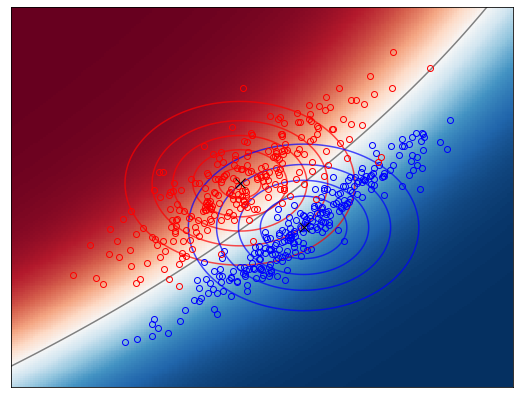

In [467]:
plt.figure(figsize=(9, 7))

# evaluate decision function
Z = nb.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
Z = Z.reshape(xx.shape)

# veamos la función de decisión y la frontera de decisión
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdBu_r)
plt.contour(xx, yy, Z, [0.5,], colors='0.5', zorder=1)

# Veamos la pdf de cada clase
# Calculo pdf de cada clase
Z1 = d1.pdf(np.c_[xx.ravel(), yy.ravel()])
Z1 = Z1.reshape(xx.shape)
plt.contour(xx, yy, Z1, levels=5, colors='r', zorder=1, alpha=0.7)

Z2 = d2.pdf(np.c_[xx.ravel(), yy.ravel()])
Z2 = Z2.reshape(xx.shape)
plt.contour(xx, yy, Z2, levels=5, colors='b', zorder=1, alpha=0.7)

xc1 = x[:, t[0] == np.unique(t.flatten()).max()]
xc2 = x[:, t[0] == np.unique(t.flatten()).min()]
    
plt.plot(*xc1, 'ob', mfc='None', label='C1')
plt.plot(*xc2, 'or', mfc='None', label='C2')

# Print centers of clusters
plt.plot(*nb.theta_.T, 'xk', ms=10)

plt.xticks(())
plt.yticks(())
plt.axis('tight')

0.00021423663608194664
